This code runs the QME algorithm on a randomly generated $(a, B)$. QME uses LPME as a subroutine, so it effectively achieves its predictions using just oracle comparisons.

Note that the QME algorithm is more susceptible to error than LPME because it uses fractions. Keep following the code for an explanation. In the code we've built in an inconsistency checker that, when flipped on, checks the cosine similarity between expected (true) gradients and the gradients determined by LPME. Later in this notebook we run trials to see the error statistics, and **even in the worst case the gradient estimation is very accurate** with cosine similarity < $10^{-6}$. We show the error can be entirely attributed to the use of fractions, and we show comparisons to so-called "well-formed" $(a, B)$ that satisfy the regularity assumption in the paper to "ill-formed" $(a, B)$ that are truly random.

The trials run in this notebook will be saved to disk in *trials/qme/well_formed* and *trials/qme/ill_formed*. *qme_results_analyze.ipynb* will use these to make graphs.

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
from scipy import spatial
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from common import Sphere, Oracle, create_a_B, normalize
from qme import QME, QMESC
from trials import NUM_TRIALS, load_qme_sphere, load_a_B, write_qme_trial, write_qme_trial_summary

# Example

In [8]:
np.random.seed(7)

# number of classes
nc = 2
# well_formed input
wf = True
# the tighter this is, the closer to the true answer (in all cases)
search_tol = 1e-3

q = nc ** 2 - nc

In [9]:
sphere = Sphere(np.zeros(q), 1.0, q)
a, B = create_a_B(sphere, q, wf)
oracle = Oracle(a, B)

In [10]:
qm = QME(sphere, oracle, search_tol, wf)
ahat, Bhat = qm.run_qme()

In [7]:
# not bad, not bad
print("a squared error:", np.linalg.norm(ahat - a))
print("B squared error:", np.linalg.norm(Bhat - B, ord='fro'))

a squared error: 0.0016076871061441085
B squared error: 0.0018994205472158382


# Trials

First run `python trials.py`.

Make sure to run all choices of $2 \leq nc \leq 5 $ and $wf \in \{True, False\}$. With 6-core multiprocessing, this should take 10-20 minutes total.

In [12]:
import multiprocessing as mp
import os

In [66]:
# -- Configurations --

# number of classes, change this as you go
nc = 2
# well-formed, change this as you go
wf = False

# set this based on your system
num_procs = 6

search_tol = 1e-2


# -- Vars --
q = nc ** 2 - nc
sphere = load_qme_sphere(nc, well_formed=wf)

folder = None
if wf:
    folder = "well_formed"
else:
    folder = "ill_formed"

if os.path.exists(f"trials/qme/{folder}/k={nc}/a_0_hat.npy"):
    print("WARNING - this class has already been run")

In [67]:
QUEUE_IN = mp.Queue()
QUEUE_OUT = mp.Queue()


def run_trial(sphere, a, B, search_tol, wf):
    oracle = Oracle(a, B)
    qm = QME(sphere, oracle, search_tol, wf)
    a_hat, B_hat = qm.run_qme()
    
    return a_hat, B_hat


def proc_run_trials(self_id, search_tol, sphere, wf):
    while True:
        data = QUEUE_IN.get(block=True)
        if data is None:
            QUEUE_IN.put(None) # so other threads can read this and exit out
            break # exit
            
        tid, a, B = data
        a_hat, B_hat = run_trial(sphere, a, B, search_tol, wf)
        
        # put result into queue out
        QUEUE_OUT.put((tid, a_hat, B_hat))

In [68]:
# start the procs
procs = []
for i in range(num_procs):
    proc = mp.Process(target=proc_run_trials, args=(
        i,
        search_tol,
        sphere,
        wf,
    ))
    proc.start()
    procs.append(proc)

In [69]:
# put in work
trial_ids = []
a_list = []
B_list = []

for i in tqdm_notebook(range(NUM_TRIALS)):
    a, B = load_a_B(nc, i, well_formed=wf)
    trial_ids.append(i)
    a_list.append(a)
    B_list.append(B)
    
    QUEUE_IN.put((i, a, B))
    
QUEUE_IN.put(None) # signal end to procs

In [70]:
# use trial_ids_out to map into the original inputs
trial_ids_out = []

a_hat_list = []
B_hat_list = []

a_err = []
B_err = []

# we should get trials many results from QUEUE_OUT
for _ in tqdm_notebook(range(NUM_TRIALS)):
    tid, a_hat, B_hat = QUEUE_OUT.get(block=True)
    
    trial_ids_out.append(tid)
    
    a_hat_list.append(a_hat)
    B_hat_list.append(B_hat)
    
    # compute error
    a_err.append( np.linalg.norm(a_hat - a_list[tid]) )
    B_err.append( np.linalg.norm(B_hat - B_list[tid], ord='fro') )

In [71]:
a_err = np.array(a_err)
B_err = np.array(B_err)

In [72]:
# save each trial result
for i in range(NUM_TRIALS):
    write_qme_trial(
        nc,
        trial_ids_out[i],
        a_hat_list[i],
        B_hat_list[i],
        well_formed=wf,
    )

# save the trial summary
write_qme_trial_summary(nc, a_err, B_err, well_formed=wf)

In [37]:
# get the worst_a, worst_B (showing nc=3, wf=True)
idx_max = np.argmax(B_err)
worst_tid = trial_ids_out[idx_max]
worst_a = a_list[worst_tid]
worst_B = B_list[worst_tid]

In [38]:
oracle = Oracle(worst_a, worst_B)
# check_i checks for gradient inconsistencies; looks at hidden oracle metric to check as it goes
qm = QME(sphere, oracle, search_tol, check_i=True)
ahat_worst, Bhat_worst = qm.run_qme()

In [39]:
worst_a

array([0.03814659, 0.01113102, 0.00639504, 0.02211164, 0.04384882,
       0.02165752, 0.00920435, 0.00430133, 0.03406827, 0.01313516,
       0.0410759 , 0.04156944, 0.02174222, 0.0341689 , 0.0038492 ,
       0.01595709, 0.02002497, 0.03151032, 0.04593458, 0.0227382 ])

In [40]:
ahat_worst

array([0.03927078, 0.01152568, 0.00666875, 0.02280867, 0.04533311,
       0.02233846, 0.00951975, 0.0045822 , 0.03499295, 0.01385993,
       0.0420959 , 0.04311976, 0.02260876, 0.0350983 , 0.00394107,
       0.01661017, 0.02072383, 0.03241034, 0.04737958, 0.02366697])

In [41]:
worst_B

matrix([[ 1.83140158e-01,  5.42630021e-03, -1.15696211e-01,
          6.53298449e-02, -7.86033645e-02, -7.93617627e-02,
          7.61182738e-02,  5.66256148e-03,  2.80383716e-02,
         -1.62097407e-01,  7.24025007e-02, -1.09865142e-01,
         -6.43263626e-02,  1.46889695e-02,  4.38294039e-02,
         -7.03834652e-02, -1.06473557e-01,  8.38605979e-02,
         -1.54548973e-02, -1.34565037e-01],
        [ 5.42630021e-03,  2.54858484e-02, -4.59235242e-03,
          1.32128749e-03, -9.76772934e-03, -5.88396279e-03,
          1.21998036e-03,  3.11372440e-03, -7.77612926e-04,
         -6.06835482e-03,  6.71261153e-03, -1.98977765e-04,
          4.11315220e-03,  5.09566355e-03, -1.82429897e-03,
         -2.80757046e-03, -3.85280700e-03,  1.67087161e-03,
         -5.77256296e-04, -5.77615833e-03],
        [-1.15696211e-01, -4.59235242e-03,  9.67645806e-02,
         -3.98447126e-02,  5.59965376e-02,  5.44424644e-02,
         -5.01072017e-02, -3.72532959e-03, -1.96647335e-02,
          1.

In [42]:
Bhat_worst

matrix([[ 1.83062818e-01,  5.42766736e-03, -1.16329794e-01,
          6.46813397e-02, -8.04531235e-02, -8.09899190e-02,
          7.65339529e-02,  5.41277576e-03,  2.71794359e-02,
         -1.63840883e-01,  7.14045090e-02, -1.11960781e-01,
         -6.55625177e-02,  1.34265772e-02,  4.39473187e-02,
         -7.12360970e-02, -1.07978962e-01,  8.32180103e-02,
         -1.72341437e-02, -1.36258109e-01],
        [ 5.42766736e-03,  2.63106923e-02, -5.07903407e-03,
          7.65573536e-04, -1.00795616e-02, -6.83360809e-03,
          9.40630167e-04,  2.96525758e-03, -1.34790587e-03,
         -6.43881410e-03,  6.22969214e-03, -1.14163389e-03,
          3.05488147e-03,  4.51111035e-03, -2.19741468e-03,
         -3.53074150e-03, -4.30544552e-03,  1.05588281e-03,
         -1.21545198e-03, -5.95062607e-03],
        [-1.16329794e-01, -5.07903407e-03,  9.44439773e-02,
         -4.08728982e-02,  5.57697494e-02,  5.36837788e-02,
         -5.17205717e-02, -3.73243508e-03, -2.04254414e-02,
          1.

In [43]:
# no inconsistencies! this means every gradient was within 1e-3 cosine similarity to the true gradient
qm.inconsistencies

[]

In [44]:
# this again verifies that the true and calculated gradients were very close

print("f_z dist:", spatial.distance.cosine(qm.qmesc.f_z, qm.f_z_opt))
print("f_neg0 dist:", spatial.distance.cosine(qm.qmesc.f_neg0, qm.f_neg0_opt))

for idx in range(0, q):
    print(f"fs_{idx} dist:", spatial.distance.cosine(qm.qmesc.fs[idx], qm.fs_opt[idx]))

f_z dist: 1.3267519913595649e-05
f_neg0 dist: 1.223734047139935e-05
fs_0 dist: 6.383712307322931e-06
fs_1 dist: 4.038893947400091e-06
fs_2 dist: 2.1684460360993363e-05
fs_3 dist: 8.083295523242384e-05
fs_4 dist: 3.239875297733619e-05
fs_5 dist: 2.6991575816426305e-05
fs_6 dist: 5.788222639702134e-05
fs_7 dist: 5.201349570049807e-06
fs_8 dist: 8.25743658252609e-05
fs_9 dist: 5.91559102847139e-06
fs_10 dist: 6.16088857556818e-05
fs_11 dist: 2.3829270870190378e-05
fs_12 dist: 4.222362962869042e-05
fs_13 dist: 1.2255648359382754e-05
fs_14 dist: 0.00012605881459526458
fs_15 dist: 5.903349865155061e-05
fs_16 dist: 1.5321378485366743e-05
fs_17 dist: 5.09985998893292e-05
fs_18 dist: 6.922988326940605e-05
fs_19 dist: 1.2330364263180016e-05


In [45]:
# try running the algo with the true gradients (normalized)
f_z_opt = normalize(qm.f_z_opt)
f_neg0_opt = normalize(qm.f_neg0_opt)
fs_opt = [normalize(i) for i in qm.fs_opt]
# QMESC = QME Slope Calculator, calculates a, B given the slope estimates
# turn off well_formed because we want to see the algorithm run directly 
# without gradient clipping (see qme.py/clip_v for an explanation)
qmesc_opt = QMESC(sphere, 5e-3, f_z_opt, f_neg0_opt, fs_opt, well_formed=False)
ahat_worst_opt, Bhat_worst_opt = qmesc_opt.compute_a_b()

In [46]:
worst_a

array([0.03814659, 0.01113102, 0.00639504, 0.02211164, 0.04384882,
       0.02165752, 0.00920435, 0.00430133, 0.03406827, 0.01313516,
       0.0410759 , 0.04156944, 0.02174222, 0.0341689 , 0.0038492 ,
       0.01595709, 0.02002497, 0.03151032, 0.04593458, 0.0227382 ])

In [47]:
# accurate!
ahat_worst_opt

array([0.03814659, 0.01113102, 0.00639504, 0.02211164, 0.04384882,
       0.02165752, 0.00920435, 0.00430133, 0.03406827, 0.01313516,
       0.0410759 , 0.04156944, 0.02174222, 0.0341689 , 0.0038492 ,
       0.01595709, 0.02002497, 0.03151032, 0.04593458, 0.0227382 ])

In [48]:
worst_B

matrix([[ 1.83140158e-01,  5.42630021e-03, -1.15696211e-01,
          6.53298449e-02, -7.86033645e-02, -7.93617627e-02,
          7.61182738e-02,  5.66256148e-03,  2.80383716e-02,
         -1.62097407e-01,  7.24025007e-02, -1.09865142e-01,
         -6.43263626e-02,  1.46889695e-02,  4.38294039e-02,
         -7.03834652e-02, -1.06473557e-01,  8.38605979e-02,
         -1.54548973e-02, -1.34565037e-01],
        [ 5.42630021e-03,  2.54858484e-02, -4.59235242e-03,
          1.32128749e-03, -9.76772934e-03, -5.88396279e-03,
          1.21998036e-03,  3.11372440e-03, -7.77612926e-04,
         -6.06835482e-03,  6.71261153e-03, -1.98977765e-04,
          4.11315220e-03,  5.09566355e-03, -1.82429897e-03,
         -2.80757046e-03, -3.85280700e-03,  1.67087161e-03,
         -5.77256296e-04, -5.77615833e-03],
        [-1.15696211e-01, -4.59235242e-03,  9.67645806e-02,
         -3.98447126e-02,  5.59965376e-02,  5.44424644e-02,
         -5.01072017e-02, -3.72532959e-03, -1.96647335e-02,
          1.

In [49]:
# accurate!
Bhat_worst_opt

matrix([[ 1.83140158e-01,  5.42630021e-03, -1.15696211e-01,
          6.53298449e-02, -7.86033645e-02, -7.93617627e-02,
          7.61182738e-02,  5.66256148e-03,  2.80383716e-02,
         -1.62097407e-01,  7.24025007e-02, -1.09865142e-01,
         -6.43263626e-02,  1.46889695e-02,  4.38294039e-02,
         -7.03834652e-02, -1.06473557e-01,  8.38605979e-02,
         -1.54548973e-02, -1.34565037e-01],
        [ 5.42630021e-03,  2.54858484e-02, -4.59235242e-03,
          1.32128749e-03, -9.76772934e-03, -5.88396279e-03,
          1.21998036e-03,  3.11372440e-03, -7.77612926e-04,
         -6.06835482e-03,  6.71261153e-03, -1.98977765e-04,
          4.11315220e-03,  5.09566355e-03, -1.82429897e-03,
         -2.80757046e-03, -3.85280700e-03,  1.67087161e-03,
         -5.77256296e-04, -5.77615833e-03],
        [-1.15696211e-01, -4.59235242e-03,  9.67645806e-02,
         -3.98447126e-02,  5.59965376e-02,  5.44424644e-02,
         -5.01072017e-02, -3.72532959e-03, -1.96647335e-02,
          1.

In [50]:
# original algo
print("a squared error:", np.linalg.norm(ahat_worst - worst_a))
print("B squared error:", np.linalg.norm(Bhat_worst - worst_B, ord='fro'))

a squared error: 0.003993552493955984
B squared error: 0.031392108520999815


In [51]:
# algo with true grads
print("a squared error:", np.linalg.norm(ahat_worst_opt - worst_a))
print("B squared error:", np.linalg.norm(Bhat_worst_opt - worst_B, ord='fro'))

a squared error: 7.442176000247124e-16
B squared error: 1.832379595782501e-14


As we can see, even on the worst trial the optimal gradients were extremely close to the measured gradients. However, using the measured gradients still resulted in large error. **Thus, the error can be entirely attributed to the fact that fractions are not robust to error.** We know it is not code error because we use the same algorithm on the true gradients and get the right answer. Evidently, this bad output CAN happen for some random inputs $(a, B)$. The *well_formed* assumption mitigates this error (discussed in the paper, code - see *common.py/check_a_B_sphere_satisfy_conditions*, and in *explore_fractional_error.ipynb*)

Also, if you look at the plot for the error (below) you will see that it is severely right-tailed.

(array([49., 92., 72., 49., 23.,  5.,  3.,  6.,  0.,  1.]),
 array([0.00652797, 0.00901438, 0.0115008 , 0.01398721, 0.01647363,
        0.01896004, 0.02144645, 0.02393287, 0.02641928, 0.02890569,
        0.03139211]),
 <a list of 10 Patch objects>)

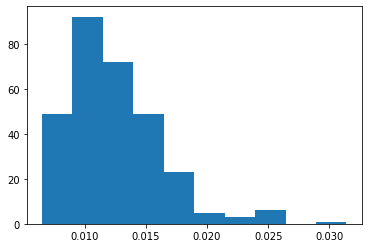

In [35]:
plt.hist(B_err)